In [ ]:
# !pip install pytesseract lanms Shapely

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import pytesseract
import cv2

import PIL
from PIL import Image, ImageFile

In [64]:
plt.rcParams["figure.figsize"] = 16, 9  # Make figures larger

In [50]:
images = glob.glob("/home/gx/mishow_objdet/data/CaptureVerification/**/*.jpg", recursive=True)
# images = glob.glob("./test_images-car_num_plates/*")
# images = glob.glob("/mnt/9C5E1A4D5E1A2116/datasets/ICDAR_2015/test_img/**/*.jpg", recursive=True)
len(images)

173

In [51]:
pytesseract.image_to_string(Image.open(np.random.choice(images)))

'MIMOS Artificial Intelligence Software\n\n \n\nDigital\nSocial\nFingerprint\n\n \n\nTechnologies\n\n \n\nBig Data Analytic Toolkits\n\nETL/GIS Toolkits DL/ML Toolkits\nCloud and Container Management\n\nRuntime &\nInfrastructure'

## Inference

In [6]:
from detect import Predictor

In [7]:
predictor = Predictor(config_path="./runs/deeplabv3plus_resnet50_scope512_merged32_icdar2015/code/configs/config.yaml",
                      device="cpu")

using device: cpu
scope: 512
scale: 4


In [8]:
# The input preprocessing that was used to train the model
predictor.preprocessing_params

{'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}

In [9]:
# The input image size (side length) / model output size (side length) ratio
predictor.scale

4

In [10]:
# The input image size that was used to train the model
predictor.scope

512

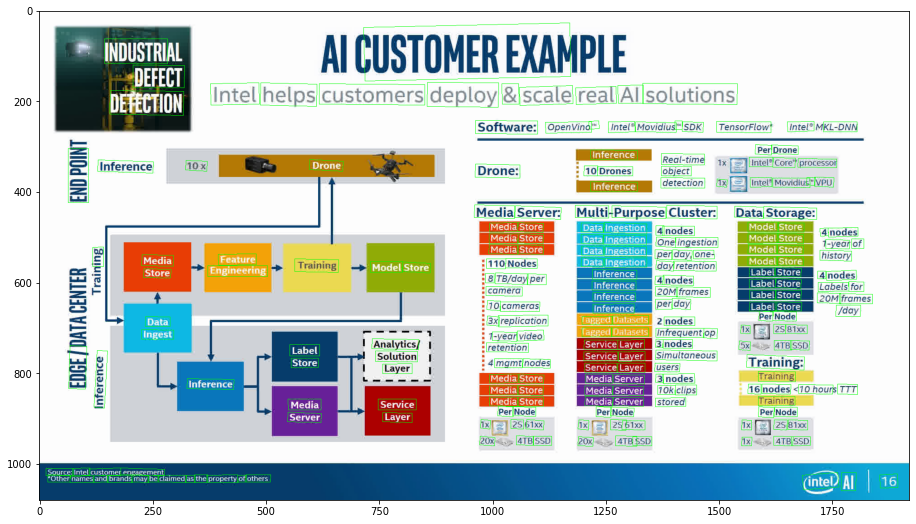

In [65]:
# Make prediction and plot image

boxes, img = predictor.predict(np.random.choice(images), 
                  save_img=False,  # Don't save image on disk
                  return_img=True,  # Return image
                  score_thresh=0.9, 
                  nms_thresh=0.2)
plt.imshow(img)

## Crop patches from image

In [67]:
def euclidean_dist(pt1: np.ndarray, pt2: np.ndarray) -> float:
    """Compute the euclidean distance between a pair of points."""
    x_diff = pt2[0] - pt1[0]
    y_diff = pt2[1] - pt1[1]
    return (x_diff ** 2 + y_diff ** 2) ** 0.5


def crop_rotated_text(img, boxes: np.ndarray):
    """Ref: https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/"""
    
    # Read image using opencv
    if isinstance(img, str):
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif isinstance(img, PIL.JpegImagePlugin.JpegImageFile):
        img = np.array(img)
    
    cropped_boxes = []
    for box in boxes:
        # Take first eight values in box, model returns 9, final value is the rotation
        # NOTE: Box from model is in the following format: top left, top right, bottom right, bottom left
        box = box[:8]
        
        if isinstance(box, list):
            box = np.array(box)
        
        # Reshape box as pairs of points
        cnt = np.array(box).reshape(-1, 2)
#         print("shape of cnt: {}".format(cnt.shape))

        # Compute width and height from box
        width = int(max(euclidean_dist(cnt[0], cnt[1]), euclidean_dist(cnt[2], cnt[3])))
        height = int(max(euclidean_dist(cnt[0], cnt[3]), euclidean_dist(cnt[1], cnt[2])))
#         print(f"width: {width}")
#         print(f"height: {height}")
    
        # This is our source points
        src_pts = cnt.astype("float32")
#         print(f"src_pts: {src_pts}")
        
        # This is our destination points that we want to warp onto
        dst_pts = np.array([
            [0, 0],
            [width-1, 0],
            [width-1, height-1],
            [0, height-1],
        ], dtype="float32")
#         print(f"dst_pts: {dst_pts}")

        # Get the perspective transformation matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Directly warp the rotated rectangle to get the straightened rectangle
        warped = cv2.warpPerspective(img, M, (width, height))
        cropped_boxes.append(warped)
        
#         print()
    
    return cropped_boxes

In [68]:
cropped = crop_rotated_text(img, boxes=boxes)
print(len(f"num crops: {len(cropped)}"))

14


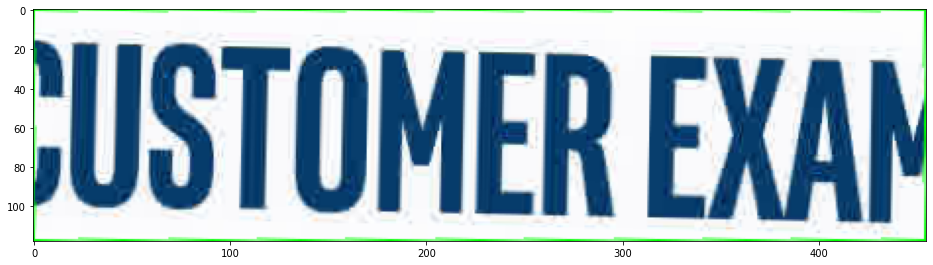

In [69]:
plt.imshow(cropped[0])

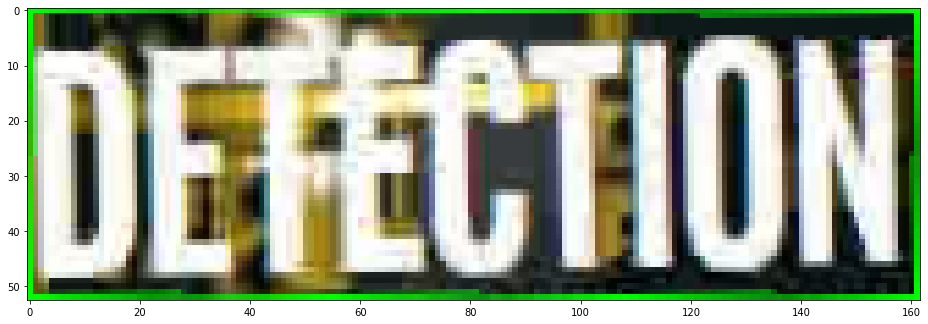

In [70]:
plt.imshow(cropped[1])

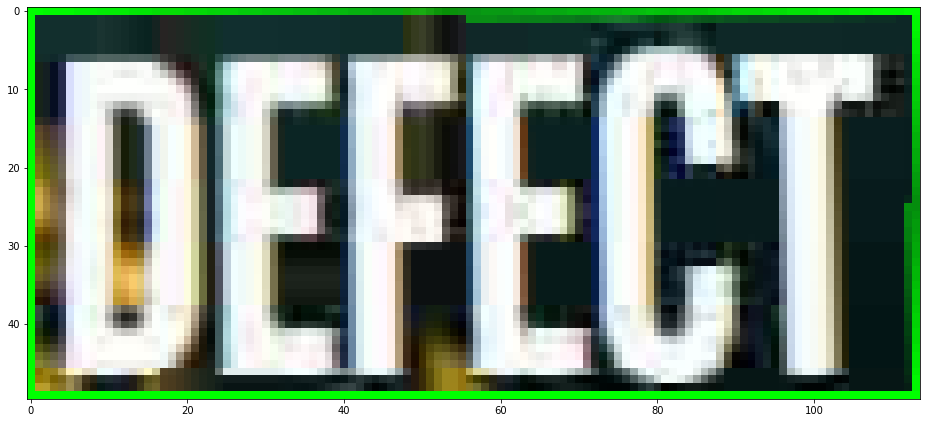

In [71]:
plt.imshow(cropped[2])

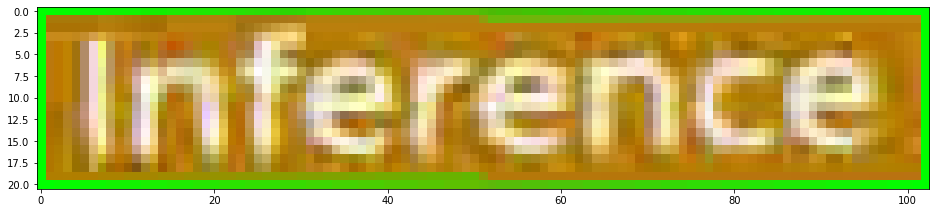

In [72]:
plt.imshow(cropped[3])

## Apply OCR on cropped regions

In [73]:
pytesseract.image_to_string(cropped[0])

''

In [74]:
pytesseract.image_to_string(cropped[1])

''

In [75]:
pytesseract.image_to_string(cropped[2])

''

In [76]:
pytesseract.image_to_string(cropped[3])

''